Nikos Bellos, Member of AUEB Students' Investment

# Network and Hierarchical Portfolios on the FTSE 100

This article studies portfolio construction on FTSE 100 equities using methods that make explicit use of the correlation structure between stocks. Using daily data from 2015–2025, we compare classical Markowitz portfolios with network-based and hierarchical portfolios built from a correlation network. All portfolios are calibrated on the 2015–2017 period and then evaluated over the 2018–2025 period, with the FTSE 100 index as the benchmark.

The idea is to start from a simple reference point (the standard mean–variance optimization) and then ask whether we can obtain better returns by using the empirical correlation network instead of relying only on a flat covariance matrix. Therefore we are going to:

* Construct Markowitz minimum-variance and maximum-Sharpe portfolios as a baseline.
* Build network portfolios from a thresholded correlation graph and hierarchical portfolios from a distance-based clustering of stocks.
* Estimate all weights once in the 2015–2017 period and then hold the portfolios long-only from 2018 to 2025.
* And then compare realized performance to the FTSE 100 index in terms of annualized returns, volatility, Sharpe ratio, maximum drawdown and tracking error.

In other words, the central question is whether using the empirical FTSE 100 correlation network to guide portfolio construction through both diversified, cluster-based portfolios and more concentrated, "hub based" picks can deliver more robust out-of-sample risk–return profiles than a conventional Markowitz allocation and the FTSE 100 index.

## Setup and Configuration


In [106]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [107]:
IN_SAMPLE_START = '2015'
IN_SAMPLE_END = '2017'
OUT_SAMPLE_START = '2018'
OUT_SAMPLE_END = '2025'
MIN_DATA_AVAILABILITY = 0.90
NETWORK_THRESHOLD_QUANTILE = 0.80
CENTRALITY_THRESHOLD = 20
HIER_MAX_CLUSTERS = 10
HERC_MAX_DEPTH = 10
PERIODS_PER_YEAR = 252


| Parameter | Value | Description |
|-----------|-------|-------------|
| In-sample period | 2015–2017 | Training period for estimating covariances and constructing portfolios |
| Out-of-sample period | 2018–2025 | Evaluation period with fixed portfolio weights |
| Min data availability | 90% | Minimum fraction of stocks with valid prices required per trading day |
| Network threshold quantile | 0.80 | Percentile of correlation distribution used for network edge threshold |
| Centrality threshold | 20 | Minimum clique membership count for clique portfolio selection |
| Hierarchical clusters | 10 | Number of clusters for cluster-equal portfolio |
| HERC max depth | 10 | Maximum recursion depth for HERC portfolio (early stopping) |
| Periods per year | 252 | Trading days per year for annualization |


## 1. Data and Preprocessing

- We use daily closing prices for FTSE 100 constituent stocks and the FTSE 100 index from 2015 to 2025. We fix the stock universe to firms that are FTSE 100 members at the end of the sample; firms that are delisted or removed from the index before 2025 are excluded, which introduces survivorship bias. The period 2015–2017 is used to estimate the covariance matrix and construct portfolios, while 2018–2025 is reserved exclusively for out-of-sample performance evaluation. We keep only stocks with sufficiently complete price histories, drop trading days where fewer than 90% of our universe have valid prices, and forward-fill short gaps in prices to obtain a balanced panel. From these cleaned prices we compute daily percentage returns and the corresponding return correlation matrix.

In [108]:
def preprocess_returns(data: pd.DataFrame, components: List[str], min_data_availability: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    available_components = [c for c in components if c in data.columns]
    if len(available_components) == 0:
        raise ValueError("No components found in data.columns")
    
    data_subset = data[available_components]
    has_data = ~data_subset.isnull().all()
    components_with_data = [c for c in available_components if has_data[c]]
    
    if len(components_with_data) == 0:
        raise ValueError("No stocks have data in the specified period")
    
    non_null_count = data_subset[components_with_data].notna().sum(axis=1)
    total_stocks = len(components_with_data)
    available_pct = non_null_count / total_stocks
    
    valid_dates = available_pct >= min_data_availability
    data_filtered = data_subset[components_with_data].loc[valid_dates].copy()
    
    if len(data_filtered) == 0:
        raise ValueError(f"No dates have at least {min_data_availability*100:.0f}% data availability")
    
    data_filled = data_filtered.ffill()
    
    data_filled = data_filled.dropna()
    
    pctreturn = data_filled.pct_change().dropna()
    
    correlation = pctreturn.corr()
    
    return pctreturn, correlation, data_filled


### Performance Metrics

We evaluate portfolio performance using several metrics computed from daily returns. We report all performance numbers at the daily frequency and then annualize them using 252 trading days per year.

**Annualized Mean Return:**
$$\mu_{\text{annual}} = 252 \times \bar{r}$$

where $\bar{r} = \frac{1}{T} \sum_{t=1}^T r_t$ is the sample mean of daily returns.

**Annualized Volatility:**
$$\sigma_{\text{annual}} = \sqrt{252} \times \hat{\sigma}$$

where $\hat{\sigma} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r})^2}$ is the sample standard deviation of daily returns.

**Sharpe Ratio** (assuming risk-free rate = 0):
$$\text{Sharpe} = \frac{\mu_{\text{annual}}}{\sigma_{\text{annual}}} = \frac{\bar{r}}{\hat{\sigma}} \sqrt{252}$$

The Sharpe ratio measures risk-adjusted returns, with higher values indicating better risk-adjusted performance.

**Maximum Drawdown:**

Maximum drawdown measures the largest peak-to-trough decline in portfolio value over the evaluation period. It captures the worst-case loss an investor would have experienced if they bought at the peak and sold at the subsequent trough. Formally, for a cumulative return series $C_t$, we compute:

$$\text{Max DD} = \min_t \frac{C_t - \max_{s \leq t} C_s}{\max_{s \leq t} C_s}$$

A more negative (or larger in absolute value) drawdown indicates higher downside risk. This metric is particularly useful for understanding tail risk and the potential for large losses during market downturns.

**Tracking Error:**

Tracking error measures how much a portfolio's returns deviate from its benchmark (in our case, the FTSE 100 index). It is computed as the annualized standard deviation of the difference between portfolio returns and benchmark returns:

$$\text{Tracking Error} = \sqrt{252} \times \text{std}(r_{\text{portfolio}} - r_{\text{benchmark}})$$

A lower tracking error means the portfolio closely follows the benchmark, while a higher tracking error indicates more active management or different risk exposures. This metric helps assess whether alternative portfolios maintain reasonable alignment with the market while potentially improving risk-adjusted returns.


In [ ]:
def compute_weighted_portfolio(prices: pd.DataFrame, weights: pd.Series, name: str = "portfolio") -> pd.Series:
    common = [c for c in weights.index if c in prices.columns]
    if not common:
        return pd.Series(0.0, index=prices.index, name=name)

    w = weights.loc[common].astype(float).values
    if w.sum() != 0:
        w = w / w.sum()

    normed = prices[common] / prices[common].iloc[0]
    portfolio = (normed * w).sum(axis=1)
    portfolio.name = name
    return portfolio

def compute_equal_weighted_portfolio(prices: pd.DataFrame, selected_stocks: List[str], name: str = "portfolio") -> pd.Series:
    selected = [s for s in selected_stocks if s in prices.columns]
    if not selected:
        return pd.Series(0.0, index=prices.index, name=name)

    normed = prices[selected] / prices[selected].iloc[0]
    portfolio = normed.mean(axis=1)
    portfolio.name = name
    return portfolio

def compute_performance_metrics(returns: pd.Series, periods_per_year: int = 252) -> Dict[str, float]:
    if len(returns) == 0 or returns.std() == 0:
        return {'mean_return': 0.0, 'volatility': 0.0, 'sharpe_ratio': 0.0}
    mean_return = returns.mean() * periods_per_year
    volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = mean_return / volatility if volatility > 0 else 0.0
    return {'mean_return': mean_return, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio}

def max_drawdown(series: pd.Series) -> float:
    
    if len(series) == 0:
        return 0.0
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def tracking_error(port_ret: pd.Series, bench_ret: pd.Series, periods_per_year: int = 252) -> float:
    
    common_idx = port_ret.index.intersection(bench_ret.index)
    if len(common_idx) == 0:
        return 0.0
    diff = port_ret[common_idx] - bench_ret[common_idx]
    return diff.std() * np.sqrt(periods_per_year)

def plot_mean_variance_scatter(
    portfolio_data: pd.DataFrame,
    portfolios: List[str],
    label_map: Dict[str, str],
    color_map: Dict[str, str],
    title: str,
    figsize: Tuple[int, int] = (7, 5)
) -> None:
    """Plot mean-variance scatter plot for portfolios."""
    comparison = {}
    for portfolio in portfolios:
        if portfolio in portfolio_data.columns:
            returns = portfolio_data[portfolio].pct_change().dropna()
            metrics = compute_performance_metrics(returns)
            comparison[portfolio] = (metrics['volatility'] * 100,
                                     metrics['mean_return'] * 100)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for portfolio, (vol, ret) in comparison.items():
        color = color_map.get(portfolio, 'blue')
        label = label_map.get(portfolio, portfolio)
        ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
        ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')
    
    vols = [v[0] for v in comparison.values()]
    rets = [v[1] for v in comparison.values()]
    ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
    ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Realized Volatility (%)', fontsize=12)
    ax.set_ylabel('Realized Return (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cumulative_returns(
    portfolio_data: pd.DataFrame,
    portfolios: List[str],
    style_map: Dict[str, Tuple[str, str, str]],
    title: str,
    figsize: Tuple[int, int] = (9, 4)
) -> None:
    """Plot cumulative returns comparison for portfolios."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for portfolio in portfolios:
        if portfolio in portfolio_data.columns:
            normalized = portfolio_data[portfolio] / portfolio_data[portfolio].iloc[0]
            color, linestyle, label = style_map.get(portfolio, ('blue', '-', portfolio))
            normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)
    
    ax.legend(loc='best', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



### Distance Metrics for Hierarchical Clustering

To build hierarchical portfolios, we need to convert correlation matrices into distance matrices that can be used for clustering. The functions below implement two distance metrics:

1. **Correlation Distance Matrix**: Converts pairwise correlations $\rho_{ij}$ into distances using the standard transformation $d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$. This maps high correlations (close to 1) to small distances and low correlations to large distances.

2. **Distance-of-Distance Matrix**: This is a second-order distance metric that measures how similar two assets are in terms of their correlation profiles. For each pair of assets $i$ and $j$, we compute the Euclidean distance between their correlation vectors (how they correlate with all other assets). This amplifies second-order relationships and tends to produce cleaner hierarchical clusters that align better with sectors or shared risk factors.

The distance-of-distance approach is particularly useful for hierarchical portfolio construction methods (HRP, HERC, hierarchical 1/N) as it captures more nuanced similarity structures than simple pairwise correlations.


In [110]:
def corr_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    corr_values = correlation.values.copy()
    np.fill_diagonal(corr_values, 1.0)
    distance = np.sqrt(0.5 * (1 - corr_values))
    np.fill_diagonal(distance, 0.0)
    return distance

def corr_distance_of_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    D = corr_distance_matrix(correlation)
    
    n = D.shape[0]
    Dtilde = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(D[:, i] - D[:, j])
            Dtilde[i, j] = dist
            Dtilde[j, i] = dist
    
    np.fill_diagonal(Dtilde, 0.0)
    return Dtilde


In [111]:
def load_ftse100_data(csv_file: str = 'ftse_stock_prices.csv') -> Tuple[pd.DataFrame, List[str]]:
    
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    components = [col for col in df.columns if col != 'FTSE100' and col != '.FTSE']
    if '.FTSE' in df.columns:
        df = df.rename(columns={'.FTSE': 'FTSE100'})
    
    metadata = df.copy()
    return metadata, components

metadata, components = load_ftse100_data('ftse_stock_prices.csv')
print(f"Loaded data for {len(components)} stocks")
print(f"Date range: {metadata.index.min()} to {metadata.index.max()}")
print(f"FTSE100 index included: {'FTSE100' in metadata.columns}")

# Display preview: headers, first 3 rows, and last 3 rows
print("\n" + "="*80)
print("Data Preview (First 3 and Last 3 rows):")
print("="*80)
print("\nColumn headers:")
print(list(metadata.columns[:10]) + ["..."] if len(metadata.columns) > 10 else list(metadata.columns))
print(f"\nFirst 3 rows:")
print(metadata.head(3))
print(f"\nLast 3 rows:")
print(metadata.tail(3))


Loaded data for 100 stocks
Date range: 2015-01-02 00:00:00 to 2025-12-05 00:00:00
FTSE100 index included: True

Data Preview (First 3 and Last 3 rows):

Column headers:
['KGF.L', 'DPLM.L', 'BP.L', 'RR.L', 'SMT.L', 'SGE.L', 'GLEN.L', 'GSK.L', 'BTRW.L', 'AV.L', '...']

First 3 rows:
            KGF.L  DPLM.L    BP.L        RR.L  SMT.L  SGE.L      GLEN.L  \
Date                                                                      
2015-01-02  336.3   714.0  410.45  272.373773  246.4  467.8  283.011475   
2015-01-05  328.1   718.0  389.70  268.908057  242.0  467.8  269.103809   
2015-01-06  316.8   725.0  391.05  269.065589  241.5  459.8  270.627936   

                  GSK.L      BTRW.L        AV.L  ...   SVT.L      SGRO.L  \
Date                                             ...                       
2015-01-02  1377.296746  405.280259  478.588302  ...  2000.0  363.103612   
2015-01-05  1363.852418  402.199953  465.151471  ...  1988.0  366.067333   
2015-01-06  1351.403966  393.927131  4

### Sample Split and Benchmark

In [112]:
in_sample_start = IN_SAMPLE_START
in_sample_end = IN_SAMPLE_END
out_sample_start = OUT_SAMPLE_START
out_sample_end = OUT_SAMPLE_END
centrality = CENTRALITY_THRESHOLD

in_sample_data = metadata[in_sample_start:in_sample_end].copy()
in_sample_returns, in_sample_correlation, in_sample_prices = preprocess_returns(
    in_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

in_sample_data = in_sample_prices.copy()

in_sample_data['FTSE100'] = metadata.loc[in_sample_data.index, 'FTSE100'].ffill()

components = list(in_sample_returns.columns)
print(f"Using {len(components)} stocks with data in the in-sample period")


Using 95 stocks with data in the in-sample period


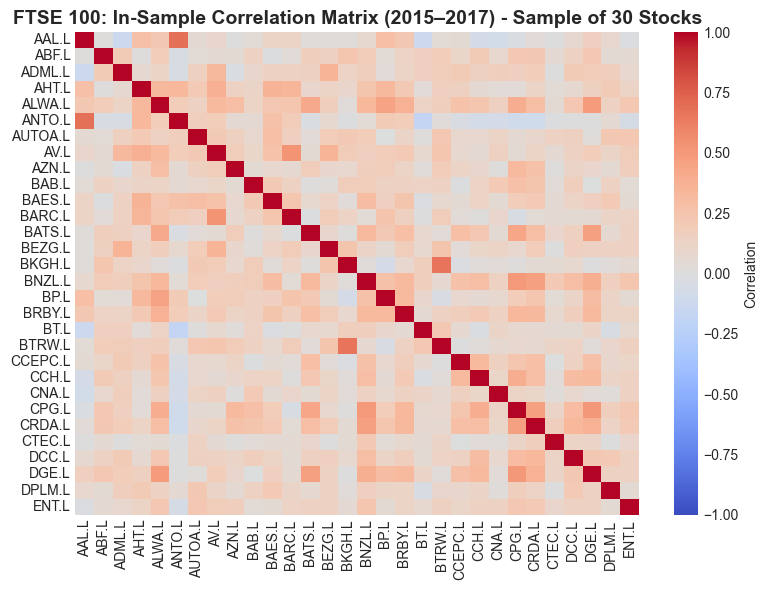

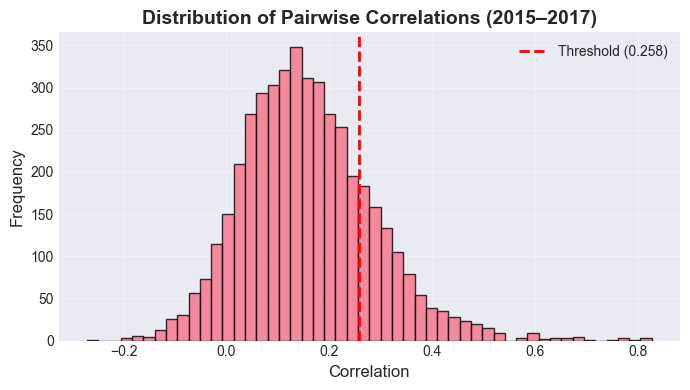

Correlation statistics:

  Mean correlation: 0.159
  Median correlation: 0.147
  Std correlation: 0.128
  Threshold q=0.80 corresponds to 0.258


In [113]:
fig, ax = plt.subplots(figsize=(8, 6))
sorted_stocks = sorted(in_sample_correlation.index)[:30]
corr_subset = in_sample_correlation.loc[sorted_stocks, sorted_stocks]
sns.heatmap(corr_subset, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True, ax=ax, 
            cbar_kws={'label': 'Correlation'})
ax.set_title('FTSE 100: In-Sample Correlation Matrix (2015–2017) - Sample of 30 Stocks', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_vals = in_sample_correlation.values
upper = corr_vals[np.triu_indices_from(corr_vals, k=1)]
upper = upper[~np.isnan(upper)]

threshold_quantile = NETWORK_THRESHOLD_QUANTILE
threshold = np.quantile(upper, threshold_quantile)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(upper, bins=50, alpha=0.8, edgecolor='black')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
ax.set_xlabel('Correlation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Pairwise Correlations (2015–2017)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Correlation statistics:\n")
print(f"  Mean correlation: {upper.mean():.3f}")
print(f"  Median correlation: {np.median(upper):.3f}")
print(f"  Std correlation: {upper.std():.3f}")
print(f"  Threshold q={threshold_quantile:.2f} corresponds to {threshold:.3f}")


## 2. Portfolio Construction

The following table summarizes all portfolio construction methods used in this analysis:

| Portfolio            | Type          | Methodology                                  |
|----------------------|---------------|-------------------------------------------|
| FTSE 100             | Benchmark     | Cap-weighted UK equity index              |
| Markowitz Min-Var    | Mean–variance | Minimize variance given Σ                 |
| Markowitz Max-Sharpe | Mean–variance | Maximize Sharpe using μ, Σ               |
| Degeneracy           | Network       | Independent set in thresholded graph     |
| Clique               | Network       | Hub stocks in many cliques                |
| Eigen Centrality     | Network       | Weights ∝ eigenvector centrality          |
| Cluster Equal        | Hierarchical  | Equal weight across clusters, then stocks|
| Hierarchical 1/N     | Hierarchical  | 50–50 splits along dendrogram             |
| HRP                  | Hierarchical  | Inverse-variance splits along tree        |
| HERC                 | Hierarchical  | Equal risk contribution up to depth       |

### 2.1 Markowitz Mean-Variance Optimization

Intuitively, the idea is very simple: the minimum-variance portfolio tries to make returns as smooth as possible (low risk), while the maximum-Sharpe portfolio tries to achieve the highest average return per unit of risk.

The Markowitz (1952) framework forms the foundation of modern portfolio theory. We implement two variants:

#### 2.1.1 Minimum-Variance Portfolio

The global minimum-variance portfolio minimizes portfolio variance subject to the constraint that weights sum to one:

$$\min_{\mathbf{w}} \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{minvar}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of returns, and $\mathbf{1}$ is a vector of ones.

#### 2.1.2 Maximum-Sharpe Portfolio

The maximum-Sharpe portfolio maximizes the risk-adjusted return (Sharpe ratio), assuming a risk-free rate of zero:

$$\max_{\mathbf{w}} \frac{\boldsymbol{\mu}^T \mathbf{w}}{\sqrt{\mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}}} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{maxsharpe}} = \frac{\boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}$$

where $\boldsymbol{\mu}$ is the vector of expected returns.

In practice, we impose long-only weights by setting any negative weights to zero and renormalizing the remainder, instead of solving the full constrained Markowitz optimization problem.

In [114]:
def compute_markowitz_weights(returns: pd.DataFrame, allow_short: bool = False) -> Tuple[pd.Series, pd.Series]:
    returns = returns.dropna(axis=1, how='all')
    mu = returns.mean()
    Sigma = returns.cov()
    Sigma_inv = np.linalg.pinv(Sigma.values)
    ones = np.ones(len(mu))
    w_minvar = Sigma_inv @ ones
    denom_minvar = ones @ w_minvar
    if denom_minvar != 0:
        w_minvar = w_minvar / denom_minvar
    w_maxsharpe = Sigma_inv @ mu.values
    denom_maxsharpe = w_maxsharpe.sum()
    if denom_maxsharpe != 0:
        w_maxsharpe = w_maxsharpe / denom_maxsharpe
    if not allow_short:
        w_minvar = np.maximum(w_minvar, 0.0)
        if w_minvar.sum() > 0:
            w_minvar = w_minvar / w_minvar.sum()
        w_maxsharpe = np.maximum(w_maxsharpe, 0.0)
        if w_maxsharpe.sum() > 0:
            w_maxsharpe = w_maxsharpe / w_maxsharpe.sum()
    w_minvar = pd.Series(w_minvar, index=mu.index, name='markowitz_minvar')
    w_maxsharpe = pd.Series(w_maxsharpe, index=mu.index, name='markowitz_maxsharpe')
    return w_minvar, w_maxsharpe

minvar_w, maxsharpe_w = compute_markowitz_weights(in_sample_returns, allow_short=False)
in_sample_data['markowitz_minvar'] = compute_weighted_portfolio(in_sample_data, minvar_w, 'markowitz_minvar')
in_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(in_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

print("Minimum-Variance Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(minvar_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_minvar_all = minvar_w[minvar_w > 0.001].sort_values(ascending=False)
top_minvar = top_minvar_all.head(3)
bottom_minvar = top_minvar_all.tail(3)
for stock, weight in top_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("\n" + "=" * 70)

print("\nMaximum-Sharpe Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(maxsharpe_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_maxsharpe_all = maxsharpe_w[maxsharpe_w > 0.001].sort_values(ascending=False)
top_maxsharpe = top_maxsharpe_all.head(3)
bottom_maxsharpe = top_maxsharpe_all.tail(3)
for stock, weight in top_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Minimum-Variance Portfolio:
Number of stocks: 52

Top 3 and Bottom 3 holdings:
  ALWA.L                 7.20%
  SSE.L                  7.07%
  FCIT.L                 5.17%
  ...
  BTRW.L                 0.29%
  BAB.L                  0.28%
  HLMA.L                 0.19%


Maximum-Sharpe Portfolio:
Number of stocks: 42

Top 3 and Bottom 3 holdings:
  REL.L                  6.98%
  ALWA.L                 6.64%
  SGRO.L                 6.51%
  ...
  RTO.L                  0.28%
  KGF.L                  0.24%
  HSBA.L                 0.20%


### 2.2 Network Portfolios

#### 2.2.1 Degeneracy Ordering Portfolio

- We start from the thresholded correlation network, where edges represent only the strongest pairwise correlations. Using the node core numbers as an ordering, we greedily construct an independent set: stocks are added only if they are not directly connected to any already selected stock. Isolated nodes (degree 0) are included automatically by this rule. By construction, no two selected stocks share a strong correlation link.

In [115]:
def create_graph(components: List[str], correlation: pd.DataFrame, 
                 threshold: float) -> Tuple[nx.Graph, Dict]:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                if corr_val > threshold:
                    graph.add_edge(stock_i, stock_j, weight=corr_val)
    
    layout = nx.spring_layout(graph, seed=42) if len(graph.nodes) > 0 else {}
    return graph, layout

def create_full_correlation_graph(components: List[str], correlation: pd.DataFrame) -> nx.Graph:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                weight = max(corr_val, 0.0)
                if weight > 0:
                    graph.add_edge(stock_i, stock_j, weight=weight)
    return graph


In [116]:
def degeneracy_ordering(graph: nx.Graph, components: List[str]) -> Tuple[List[str], List[str]]:
    degeneracy = dict(sorted(nx.core_number(graph).items(), key=lambda x: x[1]))
    independence = []
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)
    leftout = [i for i in components if i not in graph.nodes]
    return independence, leftout


In [117]:
in_sample_graph, in_sample_layout = create_graph(components, in_sample_correlation, threshold)
in_sample_full_graph = create_full_correlation_graph(components, in_sample_correlation)

In [118]:
independence, leftout = degeneracy_ordering(in_sample_graph, components)
in_sample_data['degeneracy'] = compute_equal_weighted_portfolio(in_sample_data, leftout + independence, 'degeneracy')

selected_stocks = leftout + independence
print("Degeneracy Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(selected_stocks)}")
print(f"  - Stocks not in network (leftout): {len(leftout)}")
print(f"  - Independent set from network: {len(independence)}")
print("\nTop 3 and Bottom 3 selected stocks:")
if len(selected_stocks) > 6:
    top_three = selected_stocks[:3]
    bottom_three = selected_stocks[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(selected_stocks) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(selected_stocks, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Degeneracy Portfolio:
Total stocks selected: 28
  - Stocks not in network (leftout): 0
  - Independent set from network: 28

Top 3 and Bottom 3 selected stocks:
   1. PSON.L
   2. CTEC.L
   3. GAW.L
  ...
  26. BP.L
  27. HLMA.L
  28. MRON.L


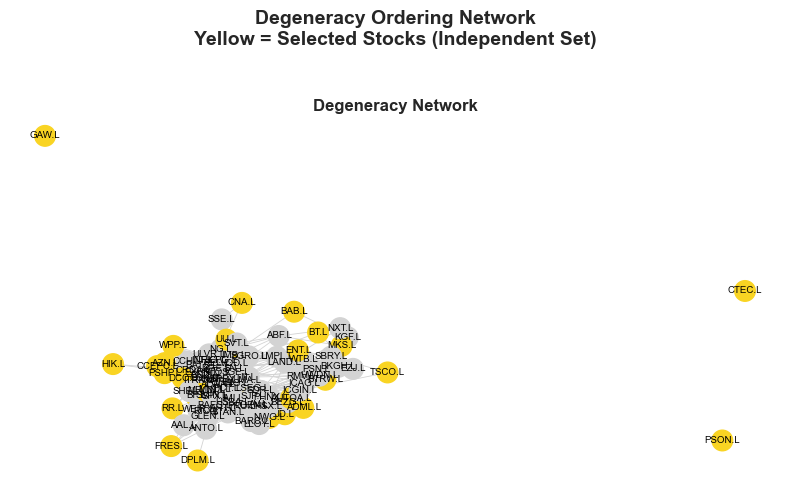

In [119]:
def draw_degeneracy_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#F9D423' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Degeneracy Ordering Network\nYellow = Selected Stocks (Independent Set)',
             fontsize=14, fontweight='bold', y=0.98)

draw_degeneracy_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    independence,
    'Degeneracy Network'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- The thresholded network still contains a meaningful number of nodes and edges, so the 80th-percentile cutoff produces a usable graph rather than an almost empty one. The degeneracy portfolio then selects stocks that are either isolated or not directly linked to each other, which results in a portfolio with very low direct correlation between holdings. In practice, this leads to a strongly diversified allocation that spreads risk across different parts of the market.

#### 2.2.2 Clique Centrality Portfolio

This method identifies hub stocks in the correlation network by counting how often each stock appears in maximal cliques. A maximal clique is a fully connected group of stocks that cannot be expanded by adding another node.

We proceed as follows:

- Find all maximal cliques in the thresholded correlation network.

- Count how many times each stock appears across these cliques (clique membership).

- Select stocks whose clique membership exceeds a chosen threshold.
If no stock meets this threshold, we select the top stocks with the highest clique counts.

The resulting portfolio concentrates on stocks that sit at the centre of many tightly connected groups. These names tend to capture common market or sector movements, leading to a more concentrated and systematic exposure compared to the degeneracy portfolio.

In [120]:
def clique_centrality(graph: nx.Graph, centrality: int = 10, top_k: int = 10) -> List[str]:
    cliques = list(nx.find_cliques(graph))
    if not cliques:
        return []
    
    flat_nodes = [j for i in cliques for j in i]
    counts = {}
    for node in set(flat_nodes):
        counts[node] = flat_nodes.count(node)
    
    selected = [node for node, c in counts.items() if c > centrality]
    
    if not selected:
        selected = [node for node, _ in sorted(counts.items(),
                                               key=lambda x: x[1],
                                               reverse=True)[:top_k]]
    return selected

In [121]:
clique_selected = clique_centrality(in_sample_graph, centrality)
in_sample_data['clique'] = compute_equal_weighted_portfolio(in_sample_data, clique_selected, 'clique')

print("Clique Centrality Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(clique_selected)}")
print("\nTop 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):")
if len(clique_selected) > 6:
    top_three = clique_selected[:3]
    bottom_three = clique_selected[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(clique_selected) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(clique_selected, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Clique Centrality Portfolio:
Total stocks selected: 38

Top 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):
   1. RKT.L
   2. III.L
   3. FCIT.L
  ...
  36. REL.L
  37. ITRK.L
  38. SMIN.L


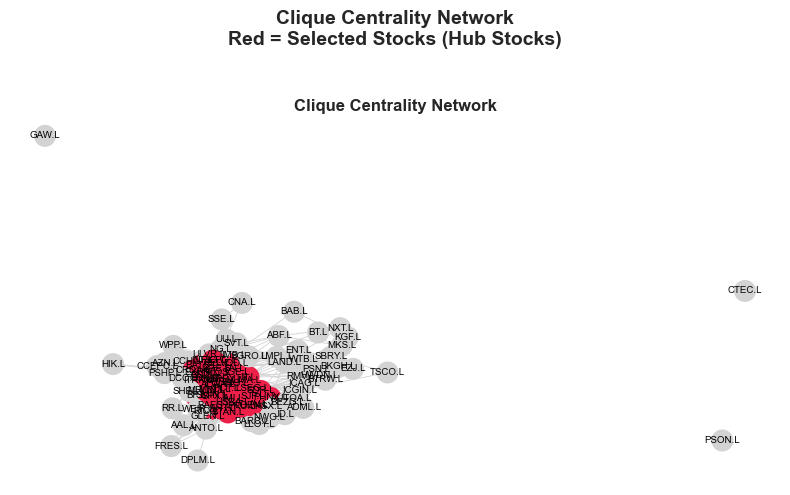

In [122]:

def draw_clique_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#EC2049' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Clique Centrality Network\nRed = Selected Stocks (Hub Stocks)',
             fontsize=14, fontweight='bold', y=0.98)

draw_clique_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    clique_selected,
    'Clique Centrality Network'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Clique centrality selects stocks that lie at the centre of many tightly connected groups in the network. These hub stocks tend to move with large parts of the market, giving the portfolio more systematic exposure. Compared with the degeneracy portfolio, this approach sacrifices some diversification in exchange for a more concentrated, factor-like tilt toward highly correlated names.

#### 2.2.3 Eigenvector Centrality Portfolio

Eigenvector centrality measures a node’s importance recursively: a stock is central if it connects to other central stocks. For the weighted adjacency matrix $\mathbf{W}$, the centrality vector $\mathbf{s}$ satisfies:

$$\lambda \mathbf{s} = \mathbf{W}\mathbf{s}$$

where $\lambda$ is the largest eigenvalue.

We normalize the centrality scores to form a long-only portfolio:
$$\mathbf{w}_{\text{central}} = \frac{\mathbf{s}}{\mathbf{1}^T \mathbf{s}}$$

This portfolio tilts toward the most systemically important stocks in the network.

In [123]:
def eigenvector_centrality_weights(graph: nx.Graph, components: List[str], inverse: bool = False) -> pd.Series:
    if len(graph.nodes) == 0:
        return pd.Series(0.0, index=components, name='eigen_centrality')
    ec_dict = nx.eigenvector_centrality_numpy(graph, weight='weight')
    ec = pd.Series(ec_dict, name='eigen_centrality')
    ec = ec.reindex(components).fillna(0.0)
    if inverse:
        ec = 1.0 / (ec.replace(0, np.nan))
        ec = ec.fillna(0.0)
    if ec.sum() != 0:
        ec = ec / ec.sum()
    return ec

In [124]:
eigen_w_central = eigenvector_centrality_weights(in_sample_full_graph, components, inverse=False)
in_sample_data['eigen_central'] = compute_weighted_portfolio(in_sample_data, eigen_w_central, 'eigen_central')

print("Eigenvector Centrality Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(eigen_w_central > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings (by eigenvector centrality):")
top_eigen_all = eigen_w_central[eigen_w_central > 0.001].sort_values(ascending=False)
top_eigen = top_eigen_all.head(3)
bottom_eigen = top_eigen_all.tail(3)
for stock, weight in top_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Eigenvector Centrality Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings (by eigenvector centrality):
  ALWA.L                 1.81%
  FCIT.L                 1.80%
  SMT.L                  1.78%
  ...
  CTEC.L                 0.46%
  PSON.L                 0.34%
  GAW.L                  0.24%


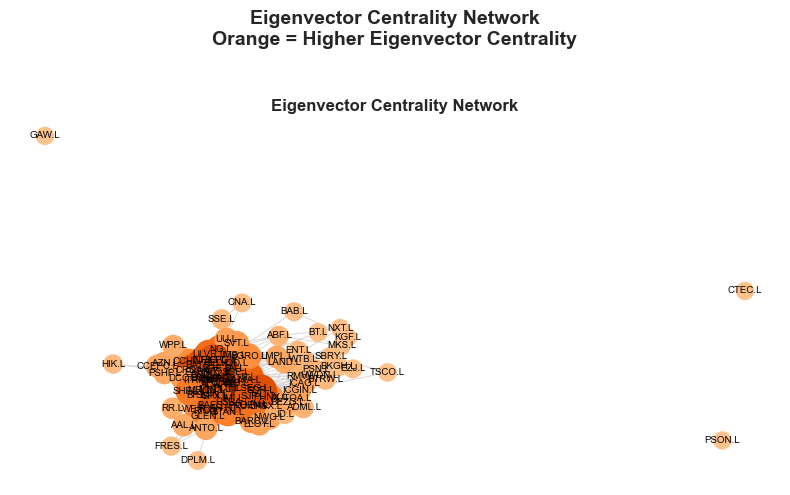

In [125]:
def compute_eigen_centrality_safe(graph):
    
    if len(graph.nodes) == 0:
        return {}
    return nx.eigenvector_centrality(graph, weight='weight', max_iter=1000)

in_ec = compute_eigen_centrality_safe(in_sample_graph)

def draw_eigen_network(ax, graph, layout, ec_dict, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    vals = np.array([ec_dict.get(n, 0.0) for n in graph.nodes])
    if vals.max() > 0:
        norm = vals / vals.max()
    else:
        norm = vals
    
    cmap = plt.cm.Oranges
    node_colors = [cmap(0.3 + 0.7 * v) for v in norm]  
    node_sizes = 150 + 600 * norm                      
    
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Eigenvector Centrality Network\nOrange = Higher Eigenvector Centrality',
             fontsize=14, fontweight='bold', y=0.98)

draw_eigen_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    in_ec,
    'Eigenvector Centrality Network'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Node size and colour intensity reflect eigenvector centrality: a stock becomes important if it is connected to other important stocks.
- The eigenvector centrality portfolio overweights these nodes in the positive correlation graph, not only in the thresholded graph we draw.
- As a result, this portfolio behaves a bit like a "network beta" trade: it has high exposure to the main market mode and less idiosyncratic diversification.

### 2.3 Hierarchical Portfolios

We cluster stocks using correlation-derived distances, then allocate within that hierarchy. The distance-of-distance metric amplifies second-order similarities and typically yields cleaner, sector-like blocks.

Summary of methods:

| Method | Distance Metric | Linkage | Allocation Rule |
|--------|----------------|---------|-----------------|
| Cluster Equal | Correlation distance | Average | Equal across clusters, then within clusters |
| Hierarchical 1/N | Distance-of-distance | Ward | 50/50 splits down the tree |
| HRP | Distance-of-distance | Single | Inverse-variance splits down the tree |
| HERC | Distance-of-distance | Ward | Equal risk contribution by cluster |

#### 2.3.1 Cluster Equal-Weight Portfolio

We cluster on correlation distance and cut the dendrogram into 10 clusters. Each cluster gets equal weight (1/K), and within a cluster, weights are equal across its members:

$$d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}, \quad w_i = \frac{1}{K \cdot n_c}$$

This yields broad diversification across the discovered correlation clusters.

In [126]:
def hierarchical_clusters_from_corr(correlation: pd.DataFrame, method: str = 'average', max_clusters: int = 10) -> Tuple[pd.Series, np.ndarray]:
    
    corr = correlation.copy()
    corr = corr.fillna(0.0)
    np.fill_diagonal(corr.values, 1.0)
    corr = corr.clip(-1.0, 1.0)
    dist = np.sqrt(0.5 * (1 - corr.values))
    dist = np.nan_to_num(dist, nan=1.0, posinf=1.0, neginf=1.0)
    condensed = squareform(dist, checks=False)
    condensed = np.nan_to_num(condensed, nan=1.0, posinf=1.0, neginf=1.0)
    Z = linkage(condensed, method=method)
    labels = fcluster(Z, max_clusters, criterion='maxclust')
    labels = pd.Series(labels, index=correlation.index, name='cluster')
    return labels, Z

def cluster_equal_weights(labels: pd.Series) -> pd.Series:
    weights = pd.Series(0.0, index=labels.index)
    clusters = labels.unique()
    n_clusters = len(clusters)
    for c in clusters:
        members = labels.index[labels == c]
        if len(members) == 0:
            continue
        weights.loc[members] = 1.0 / (n_clusters * len(members))
    weights.name = 'cluster_equal'
    return weights

In [127]:
cluster_labels, Z = hierarchical_clusters_from_corr(
    in_sample_correlation, method='average', max_clusters=HIER_MAX_CLUSTERS
)
cluster_w = cluster_equal_weights(cluster_labels)
in_sample_data['cluster_equal'] = compute_weighted_portfolio(in_sample_data, cluster_w, 'cluster_equal')

print("Hierarchical Clustering Portfolio:")
print("=" * 70)
print(f"Number of clusters: {cluster_labels.nunique()}")
print("\nCluster composition (all clusters):")
sorted_clusters = sorted(cluster_labels.unique())
for cluster_id in sorted_clusters:
    members = cluster_labels[cluster_labels == cluster_id].index.tolist()
    members_str = ", ".join(members)
    print(f"\nCluster {cluster_id} ({len(members)} stocks):")
    print(members_str)
print("=" * 70)

Hierarchical Clustering Portfolio:
Number of clusters: 10

Cluster composition (all clusters):

Cluster 1 (1 stocks):
PSHP.L

Cluster 2 (1 stocks):
GAW.L

Cluster 3 (2 stocks):
KGF.L, BAB.L

Cluster 4 (16 stocks):
BTRW.L, WTB.L, PSN.L, JD.L, MKS.L, RMV.L, HWDN.L, EZJ.L, ABF.L, ENT.L, ICAG.L, AUTOA.L, NXT.L, TSCO.L, BKGH.L, SBRY.L

Cluster 5 (1 stocks):
BT.L

Cluster 6 (2 stocks):
DPLM.L, HIK.L

Cluster 7 (40 stocks):
BP.L, SMT.L, SGE.L, GSK.L, INF.L, MNDI.L, BNZL.L, ITRK.L, VOD.L, LAND.L, CCH.L, IMB.L, SN.L, BATS.L, RTO.L, AZN.L, SSE.L, LMPL.L, CPG.L, CNA.L, IHG.L, DGE.L, ULVR.L, WPP.L, CCEPC.L, FCIT.L, EXPN.L, CRDA.L, NG.L, UU.L, PCT.L, III.L, DCC.L, BRBY.L, REL.L, ALWA.L, SVT.L, SGRO.L, RKT.L, SHEL.L

Cluster 8 (30 stocks):
RR.L, GLEN.L, AV.L, FRES.L, RIO.L, BAES.L, NWG.L, LSEG.L, AHT.L, HLMA.L, BARC.L, HSBA.L, PRU.L, PHNX.L, WEIR.L, MRON.L, ADML.L, HSX.L, BEZG.L, SMIN.L, SJP.L, STAN.L, AAL.L, LGEN.L, ANTO.L, IMI.L, SPX.L, LLOY.L, ICGIN.L, SDR.L

Cluster 9 (1 stocks):
PSON.L

Cluster

#### 2.3.2 Hierarchical 1/N (Waterfall)

A structure-driven baseline: use the distance-of-distance tree (Ward linkage), then split weight 50/50 down the tree. No risk estimates, just the hierarchy itself. This provides a transparent benchmark for the more risk-aware HRP and HERC methods.

In [128]:
def hierarchical_one_over_n_weights(
    correlation: pd.DataFrame,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = False,
) -> pd.Series:
    
    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation)
    else:
        distance_matrix = corr_distance_matrix(correlation)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(correlation.index)
    root_cluster_id = 2 * n_items - 2
    
    weights_dict = {i: 0.0 for i in range(n_items)}
    
    def assign_weight_recursive(cluster_id: int, weight: float):
        
        if cluster_id < n_items:
            # Leaf node: assign weight directly
            weights_dict[cluster_id] = weight
        else:
            # Internal cluster: split weight equally between children
            cluster_idx = cluster_id - n_items
            left_child = int(linkage_matrix[cluster_idx, 0])
            right_child = int(linkage_matrix[cluster_idx, 1])
            assign_weight_recursive(left_child, weight / 2.0)
            assign_weight_recursive(right_child, weight / 2.0)
    
    # Start from root with weight 1.0
    assign_weight_recursive(root_cluster_id, 1.0)
    
    # Convert to pd.Series
    weights = pd.Series([weights_dict[i] for i in range(n_items)], index=correlation.index)
    
    # Normalize (should already sum to 1, but ensure it)
    weights = weights / weights.sum()
    weights.name = 'hier_1N'
    
    return weights


In [129]:
h1n_weights = hierarchical_one_over_n_weights(
    in_sample_correlation,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["hier_1N"] = compute_weighted_portfolio(in_sample_data, h1n_weights, "hier_1N")

print("Hierarchical 1/N Portfolio (Waterfall):")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(h1n_weights > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_h1n_all = h1n_weights[h1n_weights > 0.001].sort_values(ascending=False)
top_h1n = top_h1n_all.head(3)
bottom_h1n = top_h1n_all.tail(3)
for stock, weight in top_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Hierarchical 1/N Portfolio (Waterfall):
Number of stocks with non-zero weight: 87

Top 3 and Bottom 3 holdings:
  ANTO.L                 6.25%
  AAL.L                  3.12%
  FRES.L                 3.12%
  ...
  CPG.L                  0.20%
  SPX.L                  0.20%
  SBRY.L                 0.20%


#### 2.3.3 Hierarchical Risk Parity (HRP) Portfolio

The Hierarchical Risk Parity (HRP) portfolio follows López de Prado (2016), but uses the distance-of-distance matrix to build the hierarchy. This tends to produce clearer clusters than a simple correlation-based distance.

Starting from the in-sample covariance matrix, we:

1. Convert correlations into a distance-of-distance matrix and run single-linkage hierarchical clustering to obtain a dendrogram.
2. Quasi-diagonalize the covariance matrix according to the dendrogram ordering, so that similar assets sit next to each other.
3. Apply recursive bisection: at each split, we divide the current cluster into two subclusters, compute their variances using an inverse-variance portfolio within each subcluster, and allocate cluster weight inversely to these variances:
   $$\alpha = \frac{\sigma_2^2}{\sigma_1^2 + \sigma_2^2}, \quad
   1 - \alpha = \frac{\sigma_1^2}{\sigma_1^2 + \sigma_2^2}$$
   where $\sigma_1^2$ and $\sigma_2^2$ are the variances of the two subclusters.

Because HRP tilts weight toward lower-variance clusters while respecting the hierarchical structure, it produces a diversified portfolio that explicitly accounts for both correlation patterns and individual asset risk, and is typically more robust than a flat mean–variance optimization.


In [130]:
def compute_inverse_variance_portfolio(cov_matrix: np.ndarray) -> np.ndarray:
    
    variances = np.diag(cov_matrix)
    inv_variances = 1.0 / np.maximum(variances, 1e-10)
    weights = inv_variances / inv_variances.sum()
    return weights

def compute_cluster_variance(cov_matrix: np.ndarray) -> float:
    
    if cov_matrix.shape[0] == 1:
        return cov_matrix[0, 0]
    
    w = compute_inverse_variance_portfolio(cov_matrix)
    variance = w.T @ cov_matrix @ w
    return variance

def quasi_diagonalize(linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    sorted_index = [int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])]
    
    while True:
        to_expand = []
        for i, idx in enumerate(sorted_index):
            if idx >= n_items:
                to_expand.append((i, idx - n_items))
        
        if not to_expand:
            break
        
        for pos, cluster_idx in reversed(to_expand):
            merged_1 = int(linkage_matrix[cluster_idx, 0])
            merged_2 = int(linkage_matrix[cluster_idx, 1])
            
            sorted_index[pos] = merged_1
            sorted_index.insert(pos + 1, merged_2)
    
    return sorted_index

def hrp_weights(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)
    
    distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights


Hierarchical Risk Parity (HRP) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 3.43%
  LMPL.L                 2.58%
  REL.L                  2.55%
  ...
  RIO.L                  0.31%
  EZJ.L                  0.30%
  GLEN.L                 0.27%


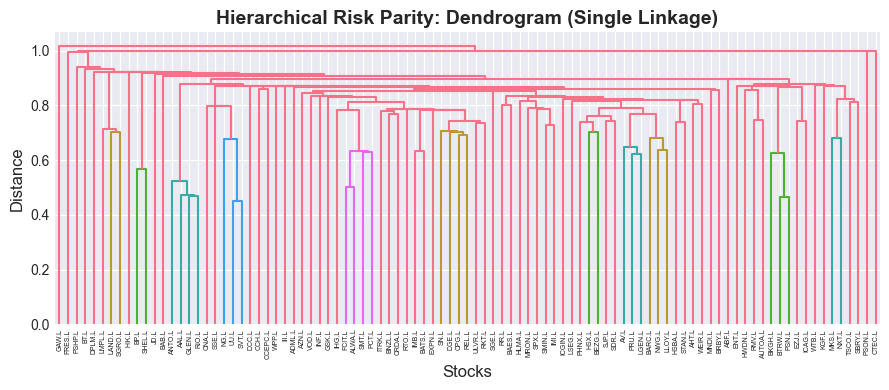

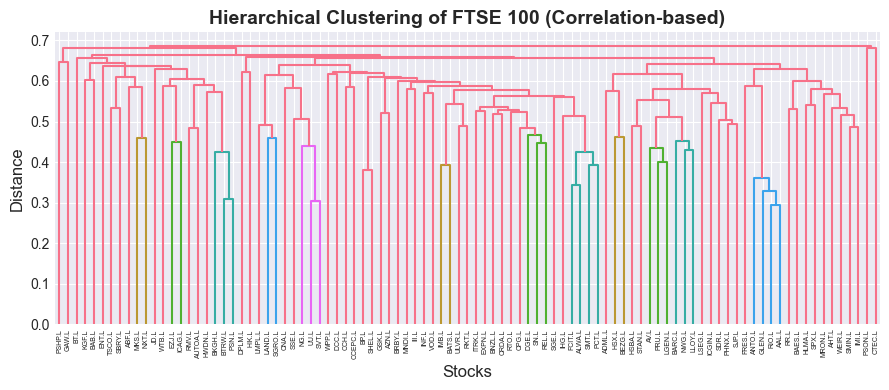

In [131]:
in_sample_cov = in_sample_returns.cov()

hrp_weights_series = hrp_weights(in_sample_cov, linkage_method='single')
in_sample_data['hrp'] = compute_weighted_portfolio(in_sample_data, hrp_weights_series, 'hrp')

print("Hierarchical Risk Parity (HRP) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(hrp_weights_series > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_hrp_all = hrp_weights_series[hrp_weights_series > 0.001].sort_values(ascending=False)
top_hrp = top_hrp_all.head(3)
bottom_hrp = top_hrp_all.tail(3)
for stock, weight in top_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

distance_hrp = corr_distance_of_distance_matrix(in_sample_correlation)
condensed_dist_hrp = squareform(distance_hrp, checks=False)
Z_hrp = linkage(condensed_dist_hrp, method='single')

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z_hrp, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Risk Parity: Dendrogram (Single Linkage)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Clustering of FTSE 100 (Correlation-based)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()



In [132]:
def herc_weights(
    covariance: pd.DataFrame,
    max_depth: int | None = None,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = True,
) -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)

    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    else:
        distance_matrix = corr_distance_matrix(correlation_df)

    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)

    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)

    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]

    weights = pd.Series(0.0, index=sorted_items)

    def split_group_recursive(group: List[int], cluster_weight: float, depth: int = 0):
        
        if len(group) == 1 or (max_depth is not None and depth >= max_depth):
            equal_w = cluster_weight / len(group)
            for i in group:
                weights.iloc[i] += equal_w
            return

        mid = len(group) // 2
        group_1 = group[:mid]
        group_2 = group[mid:]

        items_1 = [sorted_items[i] for i in group_1]
        items_2 = [sorted_items[i] for i in group_2]

        cov_1 = cov_sorted.loc[items_1, items_1].values
        cov_2 = cov_sorted.loc[items_2, items_2].values

        n1, n2 = len(group_1), len(group_2)
        w1_equal = np.ones(n1) / n1
        w2_equal = np.ones(n2) / n2

        var_1 = w1_equal.T @ cov_1 @ w1_equal
        var_2 = w2_equal.T @ cov_2 @ w2_equal

        total_var = var_1 + var_2
        if total_var > 0:
            w1 = var_2 / total_var
            w2 = var_1 / total_var
        else:
            w1 = w2 = 0.5

        split_group_recursive(group_1, cluster_weight * w1, depth + 1)
        split_group_recursive(group_2, cluster_weight * w2, depth + 1)

    split_group_recursive(list(range(n_items)), cluster_weight=1.0, depth=0)

    weights = weights / weights.sum()
    weights.name = 'herc'

    weights = weights.reindex(covariance.index).fillna(0.0)

    return weights


#### 2.3.4 Hierarchical Equal Risk Contribution (HERC)

We implement a hierarchical risk allocation scheme on the same Ward distance-of-distance tree. At each split we allocate between the two subclusters inversely to their estimated variances (using equal-weighted portfolios within each subcluster), with optional early stopping at a maximum depth. This blends the hierarchy with a risk-aware allocation rule.


In [133]:
herc_w = herc_weights(
    in_sample_cov,
    max_depth=HERC_MAX_DEPTH,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["herc"] = compute_weighted_portfolio(in_sample_data, herc_w, "herc")

print("Hierarchical Equal Risk Contribution (HERC) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(herc_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_herc_all = herc_w[herc_w > 0.001].sort_values(ascending=False)
top_herc = top_herc_all.head(3)
bottom_herc = top_herc_all.tail(3)
for stock, weight in top_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)



Hierarchical Equal Risk Contribution (HERC) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 2.71%
  SGRO.L                 2.38%
  DPLM.L                 2.29%
  ...
  AAL.L                  0.16%
  RIO.L                  0.13%
  GLEN.L                 0.11%


- The distance-of-distance metric groups stocks that have similar correlation profiles, not just high pairwise correlations. In practice, this often lines up with sectors or shared risk factors.

- Using this metric, we build hierarchical trees and then construct three portfolios:
  - Hierarchical 1/N and HERC share the same Ward-linkage dendrogram. Hierarchical 1/N splits the portfolio 50–50 at each branch of this tree and is purely structure-driven.
  - HRP uses the same distance-of-distance matrix but a single-linkage dendrogram, and then splits weights according to inverse variances, so lower-volatility clusters receive more capital.
  - HERC allocates so that clusters contribute more evenly to total risk (up to a chosen depth), aiming for a balance between diversification and risk parity.

- Conceptually, this is a “cluster first, allocate second” approach: we first organize stocks into a hierarchy based on their correlation structure, and only then assign weights. This contrasts with a flat Markowitz optimization, which works directly on the full covariance matrix without using any explicit clustering.

## 3. In-Sample Performance

In [134]:
portfolios = [
    'FTSE100',
    'markowitz_minvar',
    'markowitz_maxsharpe',
    'degeneracy',
    'clique',
    'cluster_equal',
    'eigen_central',
    'hier_1N',
    'hrp',
    'herc',
]

weights_dict = {
    'markowitz_minvar': minvar_w,
    'markowitz_maxsharpe': maxsharpe_w,
    'degeneracy': pd.Series(1.0/len(leftout + independence), index=leftout + independence) if len(leftout + independence) > 0 else pd.Series(),
    'clique': pd.Series(1.0/len(clique_selected), index=clique_selected) if len(clique_selected) > 0 else pd.Series(),
    'cluster_equal': cluster_w,
    'eigen_central': eigen_w_central,
    'hier_1N': h1n_weights,
    'hrp': hrp_weights_series,
    'herc': herc_w,
}

ftse100_returns = in_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'In-Sample Performance Metrics (2015-2017)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                        In-Sample Performance Metrics (2015-2017)                         
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         8.87%       9.00%     0.9857      -4.40%       0.00%
markowitz_minvar               16.99%       7.03%     2.4178      -3.01%       4.24%
markowitz_maxsharpe            34.64%       8.38%     4.1334      -3.73%       5.23%
degeneracy                     11.45%       8.72%     1.3132      -6.70%       7.02%
clique                         17.58%       9.75%     1.8030      -4.81%       4.08%
cluster_equal                  26.39%      11.67%     2.2616      -6.36%      11.18%
eigen_central                  16.16%       8.45%     1.9117      -3.77%       3.90%
hier_1N                        21.09%       9.03%     2.3339      -4.20%       5.20%
hrp                            14.06%       7.

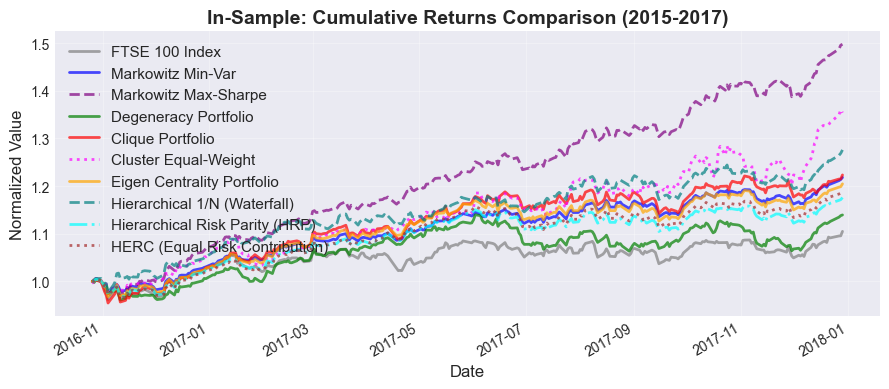

In [ ]:
style_map = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality Portfolio'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N (Waterfall)'),
    'hrp': ('cyan', '-.', 'Hierarchical Risk Parity (HRP)'),
    'herc': ('brown', ':', 'HERC (Equal Risk Contribution)'),
}

plot_cumulative_returns(
    in_sample_data,
    portfolios,
    style_map,
    'In-Sample: Cumulative Returns Comparison (2015-2017)'
)

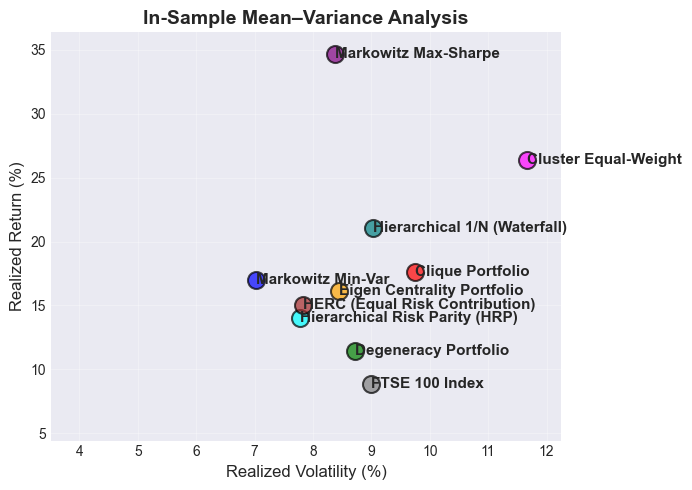

In [136]:
label_map = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality Portfolio',
    'hier_1N': 'Hierarchical 1/N (Waterfall)',
    'hrp': 'Hierarchical Risk Parity (HRP)',
    'herc': 'HERC (Equal Risk Contribution)',
}

color_map = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}

plot_mean_variance_scatter(
    in_sample_data,
    portfolios,
    label_map,
    color_map,
    'In-Sample Mean–Variance Analysis'
)

- In-sample, the Markowitz maximum-Sharpe portfolio delivers the highest return at 34.64% with a Sharpe ratio of 4.13, though this exceptional performance is likely due to overfitting given its reliance on noisy mean estimates. The cluster-equal portfolio follows with a return of 26.39% and a Sharpe ratio of 2.26, but with higher volatility (11.67%) and tracking error (11.18%) compared to max-Sharpe's 8.38% volatility.

- Most other portfolios show more moderate performance. The minimum-variance portfolio achieves a Sharpe ratio of 2.42 with a return of 16.99% and the lowest volatility at 7.03%. Hierarchical 1/N, HERC, eigenvector centrality, HRP and clique portfolios all achieve Sharpe ratios between 1.80 and 2.33, with returns ranging from 14% to 21% and volatilities between 7.77% and 9.75%. The degeneracy portfolio has the lowest Sharpe ratio among the alternatives at 1.31, with a return of 11.45%, but still outperforms the FTSE 100 benchmark which has a Sharpe ratio of 0.99.

- Now our key question is can the network and clustering based portfolios overperform the index and Markowitz portfolios?

## 4. Out-of-Sample Performance

In [137]:
out_sample_data = metadata[out_sample_start:out_sample_end].copy()
out_sample_returns, out_sample_correlation, out_sample_prices = preprocess_returns(
    out_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

out_sample_data = out_sample_prices.copy()

out_sample_data['FTSE100'] = metadata.loc[out_sample_data.index, 'FTSE100'].ffill()

out_sample_data['degeneracy'] = compute_equal_weighted_portfolio(
    out_sample_data, leftout + independence, 'degeneracy')
out_sample_data['clique'] = compute_equal_weighted_portfolio(
    out_sample_data, clique_selected, 'clique')
out_sample_data['cluster_equal'] = compute_weighted_portfolio(
    out_sample_data, cluster_w, 'cluster_equal')
out_sample_data['eigen_central'] = compute_weighted_portfolio(
    out_sample_data, eigen_w_central, 'eigen_central')
out_sample_data['hier_1N'] = compute_weighted_portfolio(
    out_sample_data, h1n_weights, 'hier_1N')
out_sample_data['hrp'] = compute_weighted_portfolio(
    out_sample_data, hrp_weights_series, 'hrp')
out_sample_data['herc'] = compute_weighted_portfolio(
    out_sample_data, herc_w, 'herc')

out_sample_data['markowitz_minvar'] = compute_weighted_portfolio(
    out_sample_data, minvar_w, 'markowitz_minvar')
out_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(
    out_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

In [138]:
ftse100_returns_os = out_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'Out-of-Sample Performance Metrics (2018–2025)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns_os) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                      Out-of-Sample Performance Metrics (2018–2025)                       
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         4.18%      15.67%     0.2669     -36.61%       0.00%
markowitz_minvar                8.52%      15.62%     0.5456     -35.54%       6.79%
markowitz_maxsharpe             9.60%      17.19%     0.5587     -37.83%       9.06%
degeneracy                     10.04%      16.17%     0.6207     -35.90%       8.70%
clique                          6.74%      17.45%     0.3864     -34.67%       7.50%
cluster_equal                  12.75%      17.43%     0.7315     -33.18%      11.79%
eigen_central                   6.73%      16.45%     0.4091     -36.27%       6.42%
hier_1N                         8.94%      16.94%     0.5279     -36.42%       6.48%
hrp                             7.77%      15.

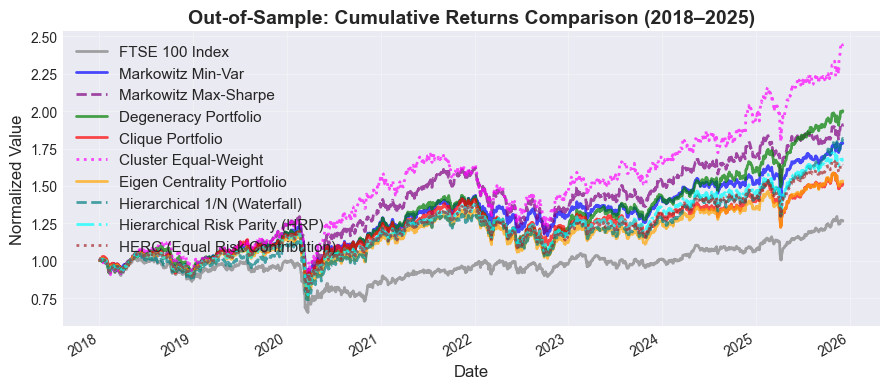

In [ ]:
plot_cumulative_returns(
    out_sample_data,
    portfolios,
    style_map,
    'Out-of-Sample: Cumulative Returns Comparison (2018–2025)'
)

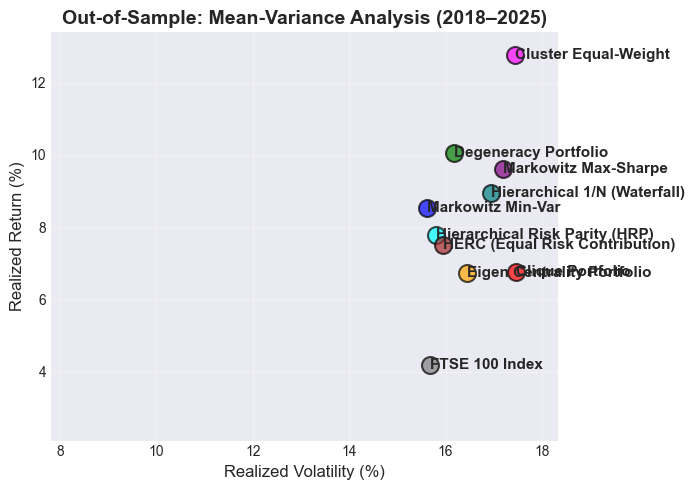

In [140]:
plot_mean_variance_scatter(
    out_sample_data,
    portfolios,
    label_map,
    color_map,
    'Out-of-Sample: Mean-Variance Analysis (2018–2025)'
)

- Out-of-sample, the Markowitz portfolios improve on the benchmark but are no longer the top performers. The minimum-variance portfolio achieves a Sharpe ratio of 0.55 with a return of 8.52% and volatility of 15.62%, while the maximum-Sharpe portfolio has a Sharpe ratio of 0.56 with a return of 9.60% and volatility of 17.19%. Both clearly outperform the FTSE 100 index, which has a Sharpe ratio of 0.27 with a return of 4.18% and volatility of 15.67%.

- The cluster-equal portfolio delivers the best out-of-sample Sharpe ratio at 0.73, with a return of 12.75% and volatility of 17.43%. However, it also has the highest tracking error at 11.79%, indicating significant deviation from the benchmark. The degeneracy portfolio follows with a Sharpe ratio of 0.62, achieving a return of 10.04% with volatility of 16.17% and a maximum drawdown of -35.90%.

- The hierarchical portfolios (hierarchical 1/N, HRP and HERC) form a middle group with Sharpe ratios between 0.47 and 0.53. Hierarchical 1/N achieves a Sharpe ratio of 0.53 with a return of 8.94% and volatility of 16.94%. HRP has a Sharpe ratio of 0.49 with a return of 7.77% and volatility of 15.81%, while HERC achieves a Sharpe ratio of 0.47 with a return of 7.50% and volatility of 15.96%. The eigenvector centrality portfolio has a Sharpe ratio of 0.41 with a return of 6.73% and volatility of 16.45%, while the clique portfolio has a Sharpe ratio of 0.39 with a return of 6.74% and volatility of 17.45%. All of these portfolios outperform the benchmark on a risk-adjusted basis.

- Overall, portfolios that explicitly use the correlation structure outperform the FTSE 100 index out-of-sample. The cluster-equal portfolio offers the highest risk-adjusted returns but with greater active risk, while the degeneracy portfolio provides a more balanced alternative. The hierarchical group (1/N, HRP, HERC) offers moderate improvements over the benchmark without the extreme volatility and tracking error of the cluster-equal approach.

## 5. Final Thoughts

- This is a stylized experiment, not a trading strategy. The FTSE 100 universe is kept fixed from 2015–2025, and I ignore rebalancing, transaction costs, taxes and funding, and assume trading at the last observed price (none of which would hold in live markets).

- The aim is not to show that Markowitz or index investing are “wrong”, but to compare different ways of using correlation information when building portfolios. Different fund managers care about different things — higher returns, smaller drawdowns or capital preservation — and face different constraints and risk appetites, so each would choose different portfolio weights, and the portfolios here are best seen as examples of trade-offs rather than a single “best” solution.

- For simplicity, I use one clean split (2015–2017 in-sample, 2018–2025 out-of-sample) and then hold all portfolios buy-and-hold. A real implementation would use rolling windows, periodic rebalancing and explicit constraints; changing these design choices would change the numbers and possibly the ranking, so the focus here is on the relative behavior of the methods in a transparent setup.

- The FTSE 100 is just a convenient, liquid test case – not a cherry-picked index – and the same tools could be applied to other markets. In more concentrated indices it may be harder to beat the benchmark, so these results should be seen as one case study, not a universal recipe.

- I focus on annualised return, volatility and Sharpe ratio, which are standard but do not fully capture tail risk or stress behaviour. A more complete study would add rolling-window analysis, trading costs, realistic constraints and downside risk measures such as Expected Shortfall (ES) or CVaR, and repeat the exercise across different periods and universes.

## 6. References

- Konstantinov, G. S., & Fabozzi, F. J. (2023). *Network Models in Finance: Expanding the Tools for Portfolio and Risk Management*. Wiley.
- Markowitz, H. (1952). "Portfolio Selection". *Journal of Finance*, 7(1), 77–91.
- López de Prado, M. (2016). "Building Diversified Portfolios that Outperform Out-of-Sample". *Journal of Portfolio Management*, 42(4), 59–69.
- Tumminello, M., Lillo, F., & Mantegna, R. N. (2010). “Correlation, hierarchies, and networks in financial markets”. *Journal of Economic Behavior & Organization*, 75(1), 40–58.